This data set represents a day's worth of visit to a fictional website. Each row represents a unique customer, identified by their unique UserID. The columns represent feature of the users visit (such as the device they were using) and things the user did on the website in that day.

* Dane binarne (0/1)
* Zmienne objaśniające (23) - wykorzystanie danych funkcjonalności na stronie
* Predykcja: Czy klient dokona zakupu? (TAK/NIE)

Zmienne:
* basket_icon_click - Did the visitor click on the shopping basket icon?
* basket_add_list - Did the visitor add a product to their shopping cart on the 'list' page?
* basket_add_detail - Did the visitor add a product to their shopping cart on the 'detail' page?
* sort_by - Did the visitor sort products on a page?
* image_picker - Did the visitor use the image picker?
* account_page_click - Did the visitor visit their account page?
* promo_banner_click - Did the visitor click on a promo banner?
* detail_wishlist_add - Did the visitor add a product to their wishlist from the 'detail' page?
* list_size_dropdown - Did the visitor interact with a product dropdown?
* closed_minibasket_click - Did the visitor close their mini shopping basket?
* checked_delivery_detail - Did the visitor view the delivery FAQ area on a product page?
* checked_returns_detail - Did the visitor check the returns FAQ area on a product page?
* sign_in - Did the visitor sign in to the website?
* saw_checkout - Did the visitor view the checkout?
* saw_sizecharts - Did the visitor view a product size chart?
* saw_delivery - Did the visitor view the delivery FAQ page?
* saw_account_upgrade - Did the visitor view the account upgrade page?
* device_mobile - Was the visitor on a mobile device?
* device_computer - Was the visitor on a desktop device?
* device_tablet - Was the visitor on a table device?
* returning_user - Was the visitor new or returning?
* loc_uk - Was the visitor located in the UK, based on their IP address?


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# Silnik ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import cross_validate
import xgboost as xgb
from hyperopt import hp
from hyperopt import fmin, tpe
from hyperopt.pyll.base import scope

In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
from sklearn.feature_selection import RFE

In [6]:
data = pd.read_csv('training_sample.csv')

In [7]:
data.head()

,UserID,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,a720-6b732349-a720-4862-bd21-644732,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,a0c0-6b73247c-a0c0-4bd9-8baa-797356,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,86a8-6b735c67-86a8-407b-ba24-333055,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,6a3d-6b736346-6a3d-4085-934b-396834,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,b74a-6b737717-b74a-45c3-8c6a-421140,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,1,1


In [8]:
data_to_join = pd.read_csv('testing_sample.csv')

In [9]:
data = pd.concat([data, data_to_join], ignore_index=True)

In [10]:
data.drop(columns=['UserID'], inplace = True)

In [11]:
X = data.iloc[:,:-1]

In [12]:
y = data.iloc[:,-1]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [15]:
data_dm = xgb.DMatrix(data=X_train.values, label=y_train.values)

<AxesSubplot:>

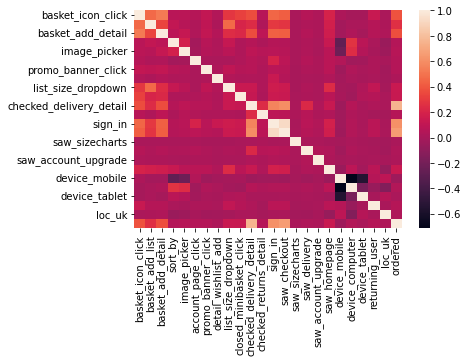

In [16]:
sns.heatmap(data.corr())

In [17]:
# Sprawdzanie niezbilansowania bazy
round((data[data == 1].count()/len(data))*100,2)

basket_icon_click           9.29
basket_add_list             7.11
basket_add_detail          10.61
sort_by                     3.67
image_picker                2.64
account_page_click          0.35
promo_banner_click          1.57
detail_wishlist_add         0.34
list_size_dropdown         22.68
closed_minibasket_click     1.63
checked_delivery_detail     5.30
checked_returns_detail      0.91
sign_in                     7.97
saw_checkout                7.07
saw_sizecharts              0.04
saw_delivery                0.54
saw_account_upgrade         0.11
saw_homepage               28.89
device_mobile              68.09
device_computer            19.58
device_tablet              12.63
returning_user             53.35
loc_uk                     93.20
ordered                     3.15
dtype: float64

PROBLEM NIEZBILANSOWANEJ BAZY (zmienna objaśniana - 3% 1 względem 97% 0)

In [18]:
positive_ordered = data[data['ordered']==1]

In [19]:
# Oblicznie stosunku 0 do 1 w y - argument do xgb classifier żeby zrównoważyć dane
neg_samples = np.sum(y == 0)
pos_samples = np.sum(y == 1)
scale_pos_weight = neg_samples / pos_samples

In [20]:
# Modele na początek (niezbilansowane, wszystkie zmienne, domyślne hiperparametry)
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = GaussianNB() 
xgb_cl = xgb.XGBClassifier()

In [21]:
# Lista modeli benchmarkowych
models = [lr, dt, rf, nb, xgb_cl]

In [22]:
# Metryki
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

Zagadnienie: Klasyfikacja

Na początek 5 modeli:
* LogisticRegression()
* DecisionTreeClassifier()
* RandomForestClassifier()
* GaussianNB() 
* XGBClassifier()

Wszystkie: niezbilansowane, domyślne hiperparametry, na podstawie wszystkich zmiennych objaśniających

Metryki:
* accuracy
* precision
* recall
* f1
* ROC AUC

W rozpatrywanym przypadku zwracamy szczególną uwagę na f1, precision i recall (przy niezbilansowanych danych accuracy nie będzie miarodajne)

C:\Users\ZaborowskaA\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Dla LogisticRegression: Accuracy: 0.993 | F1 Score: 0.947 | AUC Score: 0.997 | Precision: 0.914 | Recall: 0.987


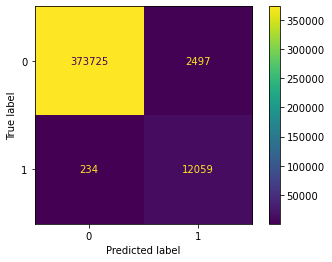

Dla DecisionTreeClassifier: Accuracy: 0.992 | F1 Score: 0.94 | AUC Score: 0.983 | Precision: 0.914 | Recall: 0.969


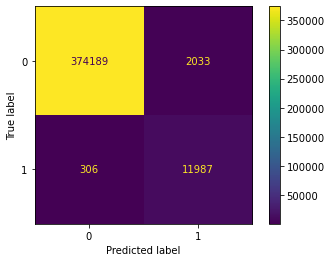

Dla RandomForestClassifier: Accuracy: 0.993 | F1 Score: 0.944 | AUC Score: 0.995 | Precision: 0.914 | Recall: 0.979


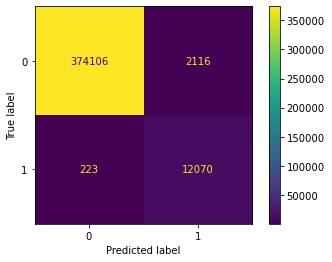

Dla GaussianNB: Accuracy: 0.988 | F1 Score: 0.918 | AUC Score: 0.995 | Precision: 0.866 | Recall: 0.988


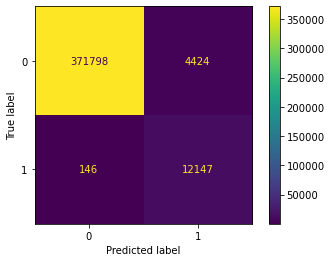

Dla XGBClassifier: Accuracy: 0.993 | F1 Score: 0.946 | AUC Score: 0.997 | Precision: 0.915 | Recall: 0.983


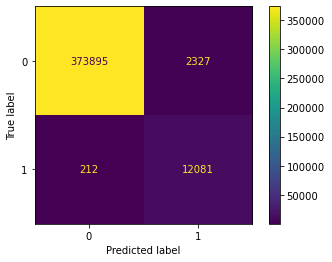

In [23]:
results = []

for model in models:
    # Trenowanie
    model.fit(X_train, y_train) 
    
    # Crossvalidation
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    
    # Wyciąganie metryk
    accuracy = round(np.mean(scores['test_accuracy']),3)
    f1 = round(np.mean(scores['test_f1_macro']),3)
    AUC = round(np.mean(scores['test_roc_auc']),3)
    precision = round(np.mean(scores['test_precision_macro']),3)
    recall = round(np.mean(scores['test_recall_macro']),3)
    
    # Macierz pomyłek
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    
    # Metryki do listy pod df
    results.append({
        'model': model.__class__.__name__,
        'auc': AUC,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    
    # Wydruk
    print('Dla {}: Accuracy: {} | F1 Score: {} | AUC Score: {} | Precision: {} | Recall: {}'.format(type(model).__name__, accuracy, f1, AUC, precision, recall))
    
    # Macierz pomyłek graficznie
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()  

PODSUMOWANIE WYNIKÓW DLA MODELI PODSTAWOWYCH:

In [24]:
# Porównanie metryk powyższych modeli w df
results_df = pd.DataFrame.from_records(results) 
results_df

,model,auc,accuracy,f1,precision,recall
0,LogisticRegression,0.997,0.993,0.947,0.914,0.987
1,DecisionTreeClassifier,0.983,0.992,0.940,0.914,0.969
2,RandomForestClassifier,0.995,0.993,0.944,0.914,0.979
3,GaussianNB,0.995,0.988,0.918,0.866,0.988
4,XGBClassifier,0.997,0.993,0.946,0.915,0.983


In [25]:
feature_names = data.columns[:-1]

In [26]:
def feaimport(model):
    importances = model.feature_importances_
    feature_importances = pd.Series(importances, index=feature_names)
    print(model.__class__.__name__ + ' - feature importances')
    return feature_importances.nlargest(20).plot(kind='barh')

DecisionTreeClassifier - feature importances


<AxesSubplot:>

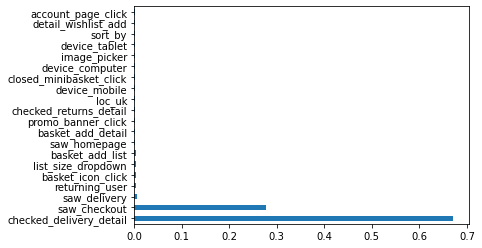

In [27]:
feaimport(dt)

RandomForestClassifier - feature importances


<AxesSubplot:>

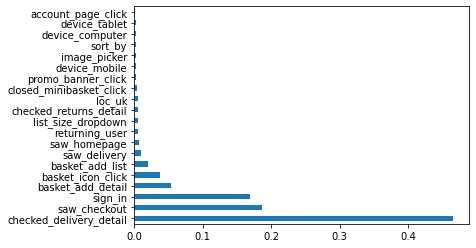

In [28]:
feaimport(rf)

XGBClassifier - feature importances


<AxesSubplot:>

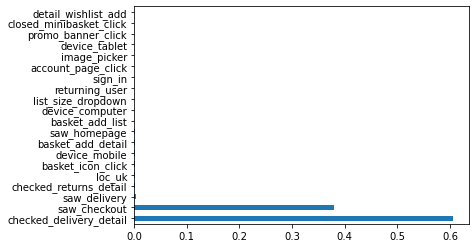

In [29]:
feaimport(xgb_cl)

Nawet podstawowe modele są bardzo skuteczne. Natomiast zauważamy, że zmienna 'checked_delivery_detail' jest na tyle skorelowana, że tak właściwie implikuje zakup. Wydaje się, że taki model nie niesie za sobą wartości biznesowej i stąd usuwamy tą zmienną z danych do modelu. 
Dodatkowo usuwamy 10 zmiennych które zupełnie nie mają wpływu na predykcję. Wykorzystujemy do tego celu recursive feature elimination (RFE).

In [30]:
selector = RFE(xgb_cl, n_features_to_select=11, step=1)
selector.fit(X_train, y_train)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, gpu_id=None,
                            grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_bin=None, max_cat_threshold=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, ...),
    n_fea

In [31]:
data.drop(columns=['ordered']).columns[selector.support_]

Index(['basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'checked_delivery_detail', 'checked_returns_detail', 'saw_checkout',
       'saw_delivery', 'saw_homepage', 'device_mobile', 'returning_user',
       'loc_uk'],
      dtype='object')

In [32]:
selected_features = ['basket_icon_click', 'basket_add_list', 'basket_add_detail',
                     'checked_returns_detail', 'saw_checkout',
                     'saw_delivery', 'saw_homepage', 'device_mobile', 'returning_user',
                     'loc_uk', 'ordered']

In [33]:
data = data[selected_features]

In [34]:
data.head()

,basket_icon_click,basket_add_list,basket_add_detail,checked_returns_detail,saw_checkout,saw_delivery,saw_homepage,device_mobile,returning_user,loc_uk,ordered
0,0,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,1,1,1,0
3,0,0,0,0,0,0,0,1,1,1,0
4,0,1,0,0,1,0,1,0,0,1,1


In [35]:
X = data.iloc[:,:-1]

In [36]:
y = data.iloc[:,-1]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [39]:
data_dm = xgb.DMatrix(data=X_train.values, label=y_train.values)

<AxesSubplot:>

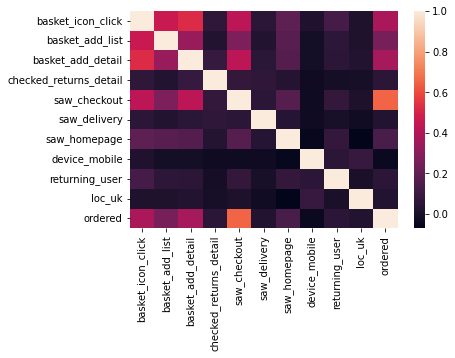

In [40]:
sns.heatmap(data.corr())

Ponownie sprawdzamy podstawowe modele. 

Dla LogisticRegression: Accuracy: 0.976 | F1 Score: 0.799 | AUC Score: 0.99 | Precision: 0.813 | Recall: 0.785


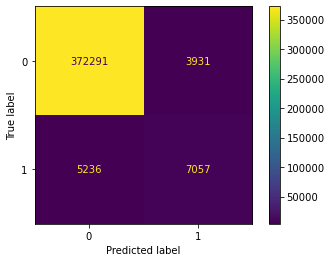

Dla DecisionTreeClassifier: Accuracy: 0.978 | F1 Score: 0.836 | AUC Score: 0.988 | Precision: 0.806 | Recall: 0.874


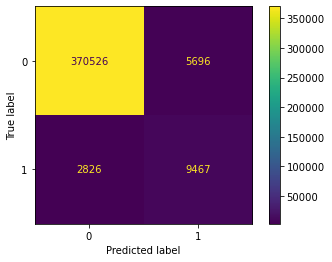

Dla RandomForestClassifier: Accuracy: 0.978 | F1 Score: 0.837 | AUC Score: 0.989 | Precision: 0.806 | Recall: 0.876


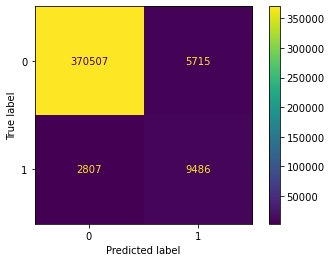

Dla GaussianNB: Accuracy: 0.961 | F1 Score: 0.798 | AUC Score: 0.988 | Precision: 0.723 | Recall: 0.98


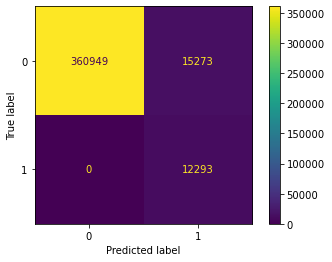

Dla XGBClassifier: Accuracy: 0.978 | F1 Score: 0.837 | AUC Score: 0.99 | Precision: 0.806 | Recall: 0.875


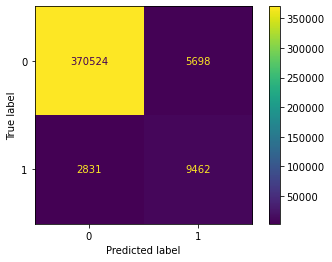

In [41]:
results2 = []

for model in models:
    # Trenowanie
    model.fit(X_train, y_train) 
    
    # Crossvalidation
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    
    # Wyciąganie metryk
    accuracy = round(np.mean(scores['test_accuracy']),3)
    f1 = round(np.mean(scores['test_f1_macro']),3)
    AUC = round(np.mean(scores['test_roc_auc']),3)
    precision = round(np.mean(scores['test_precision_macro']),3)
    recall = round(np.mean(scores['test_recall_macro']),3)
    
    # Macierz pomyłek
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    
    # Metryki do listy pod df
    results2.append({
        'model': model.__class__.__name__,
        'auc': AUC,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    
    # Wydruk
    print('Dla {}: Accuracy: {} | F1 Score: {} | AUC Score: {} | Precision: {} | Recall: {}'.format(type(model).__name__, accuracy, f1, AUC, precision, recall))
    
    # Macierz pomyłek graficznie
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()  

PODSUMOWANIE WYNIKÓW DLA MODELI PODSTAWOWYCH (ograniczone zmienne, domyślne hiperparametry, niezbilansowane dane):

In [42]:
# Porównanie metryk powyższych modeli w df
results2_df = pd.DataFrame.from_records(results2) 
results2_df

,model,auc,accuracy,f1,precision,recall
0,LogisticRegression,0.990,0.976,0.799,0.813,0.785
1,DecisionTreeClassifier,0.988,0.978,0.836,0.806,0.874
2,RandomForestClassifier,0.989,0.978,0.837,0.806,0.876
3,GaussianNB,0.988,0.961,0.798,0.723,0.980
4,XGBClassifier,0.990,0.978,0.837,0.806,0.875


In [43]:
feature_names = data.columns[:-1]

DecisionTreeClassifier - feature importances


<AxesSubplot:>

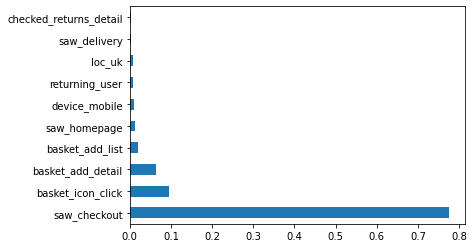

In [44]:
feaimport(dt)

RandomForestClassifier - feature importances


<AxesSubplot:>

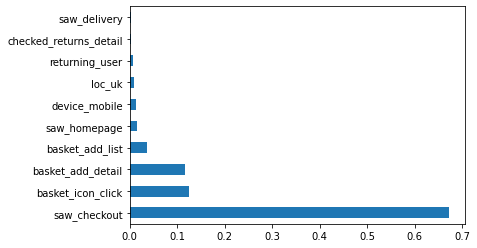

In [45]:
feaimport(rf)

XGBClassifier - feature importances


<AxesSubplot:>

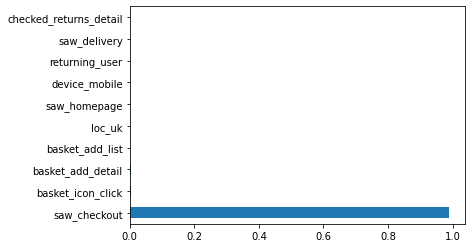

In [46]:
feaimport(xgb_cl)

Następnie dla powyższych zoptymalizowaliśmy hiperparametry z użyciem HYPEROPT (+zbalansowanie danych)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from functools import partial
from hyperopt import SparkTrials
from hyperopt import fmin, hp, tpe, SparkTrials, space_eval, STATUS_OK, Trials

In [58]:
classifiers = [
     {
        'name': 'LogisticRegressionClassifier()',
        'class': LogisticRegression(class_weight='balanced'),
        'max_evals': 20,
        'params': {
            'C': hp.loguniform('C', -5, 2),
            'max_iter': hp.quniform('max_iter', 100, 1000, 100)
            }
    },
    {
        'name': 'DecisionTreeClassifier()',
        'class': DecisionTreeClassifier(class_weight='balanced'),
        'max_evals': 20,
        'params': {
            'max_depth': hp.choice('max_depth', range(2, 15)),
            'max_features': hp.choice('max_features', range(1,10))
            }
    },
    {
        'name': 'RandomForestClassifier()',
        'class': RandomForestClassifier(class_weight='balanced'),
        'max_evals': 20,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 10, 250),
            'max_depth': hp.choice('max_depth', range(2, 15))
           }
    },
    {
        'name': 'XGBClassifier()',
        'class': XGBClassifier(scale_pos_weight=scale_pos_weight),
        'max_evals': 20,
        'params' : {
            'n_estimators': hp.uniformint('n_estimators', 10, 250),
            'max_depth': hp.choice('max_depth', range(1, 15)),
            'learning_rate': hp.loguniform('learning_rate', -5, 0)
        }
    }
    
]

In [59]:
def objective(space):
    # miejsce na parametry dla Pipeline
    pipe_params = {}
 
    # parametry dla estymatora i słownik
    for s in space:
        pipe_params[f"classifier__{s}"] = space[s]
    
    # dostrajanie Pipeline
    pipeline.set_params(**pipe_params)
    
    # oceniamy model - cross-validacja i średnia dla f1
    score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="f1").mean()
 
    return {'loss': 1- score, 'status': STATUS_OK, 'f1': score}

In [60]:
trials_df = []
 
for cl in classifiers:
    cl_name = cl['class'].__class__.__name__
    print(f"\n\n{cl_name}")
 
    pipeline = Pipeline(steps=[('classifier', cl['class'])])
 
    space = {}
    for k in cl['params']:
        space[k] = cl['params'][k]
 
    max_evals = cl['max_evals']
 
    trials = Trials()
    best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
 
    best_params = space_eval(space, best)
    print('\nThe best params:')
    print ("{:<30} {}".format('Parameter','Selected'))
    for k, v in best_params.items():
        print ("{:<30} {}".format(k, v))
 
    for trial in trials.trials:
        trials_df.append({
            'classifier': cl_name,
            'loss': trial['result']['loss'],
            'f1': trial['result']['f1'],
            'params': trial['misc']['vals']
            })



LogisticRegression
100%|██████████| 20/20 [03:40<00:00, 11.04s/trial, best loss: 0.382536033876988] 

The best params:
Parameter                      Selected
C                              6.986112795514741
max_iter                       900.0


DecisionTreeClassifier
100%|██████████| 20/20 [00:30<00:00,  1.53s/trial, best loss: 0.3600231382713781]

The best params:
Parameter                      Selected
max_depth                      9
max_features                   9


RandomForestClassifier
100%|██████████| 20/20 [24:31<00:00, 73.56s/trial, best loss: 0.3595794740283249]  

The best params:
Parameter                      Selected
max_depth                      13
n_estimators                   162


XGBClassifier
100%|██████████| 20/20 [33:41<00:00, 101.09s/trial, best loss: 0.3604699596838504]

The best params:
Parameter                      Selected
learning_rate                  0.5938830649431098
max_depth                      3
n_estimators                   165


Dla LogisticRegression: Accuracy: 0.976 | F1 Score: 0.799 | AUC Score: 0.99 | Precision: 0.813 | Recall: 0.785


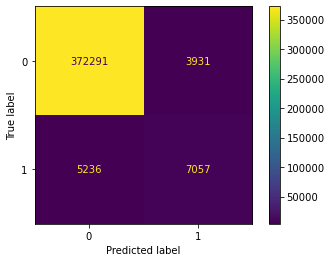

Dla DecisionTreeClassifier: Accuracy: 0.978 | F1 Score: 0.836 | AUC Score: 0.988 | Precision: 0.806 | Recall: 0.874


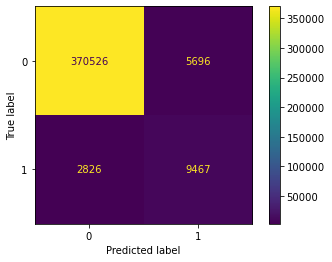

Dla RandomForestClassifier: Accuracy: 0.978 | F1 Score: 0.836 | AUC Score: 0.989 | Precision: 0.806 | Recall: 0.873


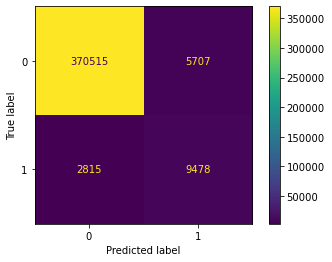

Dla GaussianNB: Accuracy: 0.961 | F1 Score: 0.798 | AUC Score: 0.988 | Precision: 0.723 | Recall: 0.98


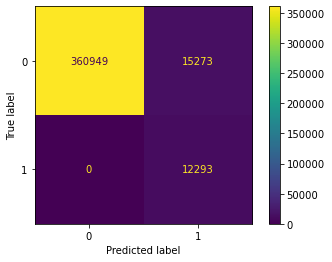

Dla XGBClassifier: Accuracy: 0.978 | F1 Score: 0.837 | AUC Score: 0.99 | Precision: 0.806 | Recall: 0.875


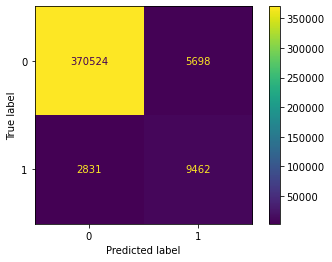

,model,auc,accuracy,f1,precision,recall
0,LogisticRegression,0.990,0.976,0.799,0.813,0.785
1,DecisionTreeClassifier,0.988,0.978,0.836,0.806,0.874
2,RandomForestClassifier,0.989,0.978,0.836,0.806,0.873
3,GaussianNB,0.988,0.961,0.798,0.723,0.980
4,XGBClassifier,0.990,0.978,0.837,0.806,0.875


In [62]:
#Zoptymalizowane modele
lr = LogisticRegression(class_weight='balanced', C=7, max_iter= 900)
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_features=9)
rf = RandomForestClassifier(class_weight='balanced', max_depth=13, n_estimators=162)
xgb_cl = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, learning_rate=0.59, max_depth=3, n_estimators=165)

results3 = []

for model in models:
    # Trenowanie
    model.fit(X_train, y_train) 
    
    # Crossvalidation
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    
    # Wyciąganie metryk
    accuracy = round(np.mean(scores['test_accuracy']),3)
    f1 = round(np.mean(scores['test_f1_macro']),3)
    AUC = round(np.mean(scores['test_roc_auc']),3)
    precision = round(np.mean(scores['test_precision_macro']),3)
    recall = round(np.mean(scores['test_recall_macro']),3)
    
    # Macierz pomyłek
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    
    # Metryki do listy pod df
    results3.append({
        'model': model.__class__.__name__,
        'auc': AUC,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    })
    
    # Wydruk
    print('Dla {}: Accuracy: {} | F1 Score: {} | AUC Score: {} | Precision: {} | Recall: {}'.format(type(model).__name__, accuracy, f1, AUC, precision, recall))
    
    # Macierz pomyłek graficznie
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()  
    
# Porównanie metryk powyższych modeli w df
results3_df = pd.DataFrame.from_records(results3) 
results3_df.sort_values(by='f1')

[Text(0, 0, 'LogisticRegression'),
 Text(1, 0, 'DecisionTreeClassifier'),
 Text(2, 0, 'RandomForestClassifier'),
 Text(3, 0, 'GaussianNB'),
 Text(4, 0, 'XGBClassifier')]

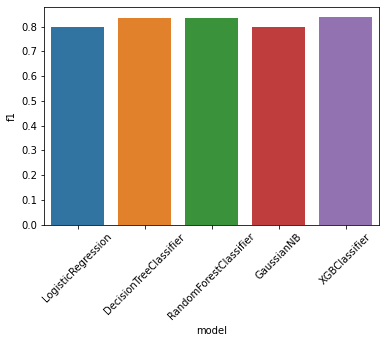

In [69]:
my_plot = sns.barplot(data=results3_df, x="model", y="f1")
#rotate x-axis labels
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)

In [72]:
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_features=9)
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=9, max_features=9)

WNIOSKI:
* Na decyzję zakupową praktycznie bez wpływu na analizowanej stronie pozostają takie czynniki jak: zalogowanie, urządzenie (mobilne/stacjonarne) itd 
* Klient sprawdzający warunki dostawy najprawdopodobniej dokona finalizacji zamówienia?
* Trudne dane? / Brak pola do preprocessingu
* Model zdominowany przez 1/2 zmienne a po ich usunięciu praktycznie działa losowo 